In [467]:
import numpy as np
import pandas as pd
import re
import os
from io import StringIO

from sklearn.externals import joblib
from scipy.sparse import csr_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

%matplotlib inline

# Релизация модели FM

In [468]:
def RMSE_score(y_pred, y_real):
    return np.sqrt(np.sum(np.power(y_pred - y_real, 2)) / y_pred.shape[0])

def R2_score(y_pred, y_real):
    return 1 - np.sum(np.power(y_pred - y_real, 2)) / np.sum(np.power(y_real - np.mean(y_real), 2))

def R2_adj_score(y_pred, y_real, features):
    R2 = R2_score(y_pred, y_real)
    return 1 - (1 - R2) * (y_real.shape[0] - 1) / (y_real.shape[0] - features - 1)

In [469]:
np.array([1,2]).reshape(-1, 1) * np.array([[1, 1], [3, 4]])

array([[1, 1],
       [6, 8]])

In [470]:
class SGD2WAYFactorizationMachine(object):
    def __init__(self, k=5, epochs=5, batch_size = 64, epsilon=1e-4, step=0.001, step_V=None, verbose=0, nobs_verbose=10):
        self.epochs = epochs
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.step = step
        self.verbose = verbose
        self.nobs_verbose = nobs_verbose
        if step_V:
            self.stepV = step_V
        else:
            self.stepV = self.step / 10
        self.k = k
        
        self.w0 = None
        self.w1 = None
        self.V = None
        
        self.Z = None
        self.Z_squared = None

    def fit(self, X, Y):
        self.w0 = 0
        self.w1 = np.random.normal(size=X.shape[1], scale=.1)
        self.V = np.random.normal(size=(X.shape[1], self.k), scale=.1)
        
        n = X.shape[0]
        for epoch in range(2, self.epochs + 2):
            batch_indices = np.random.choice(n, self.batch_size)
            x = X[batch_indices, :]
            y = Y[batch_indices]
            
            y_hat = self.predict(x)
            dy = -2 * (y - y_hat).reshape(-1, 1)
            self.w0 -= np.mean(dy) * self.step
            self.w1 -= np.mean(dy * x, axis=0) * self.step
            
            for f in range(self.k):
                left = x * (x @ self.V[:, f]).reshape(-1, 1)
                right = np.power(x, 2) * self.V[:, f]
                self.V[:, f] -=  np.mean(dy * (left - right), axis=0) * self.stepV
    
    def calculate_nonlinear_part(self, X):
        self.Z = X @ self.V
        self.Z_squared = np.power(self.Z, 2)
        self.squared_Z = np.power(X, 2) @ np.power(self.V, 2)
        return 1/2 * np.sum(self.Z_squared - self.squared_Z, axis=1)
        
    def predict(self, X):
        return np.array(self.w0 + X @ self.w1) + self.calculate_nonlinear_part(X)

# Проверка корректности работы алгоритма на примере искусственного датасета

# и сравнение с SGD регрессором sklearn

In [471]:
from sklearn.datasets import make_regression
from sklearn.linear_model import SGDRegressor

In [472]:
X, y, coefs = make_regression(n_samples=10000, n_features=4, n_targets=4, n_informative=2, coef=True)

In [473]:
X = np.concatenate([X, y[:, :-1]], axis=1)
y = y[:, -1]

In [474]:
fm = SGD2WAYFactorizationMachine(epochs=20000, batch_size=128, k=8, step=1e-6, step_V=1e-10)
reg = SGDRegressor(fit_intercept=True, penalty='none', shuffle=False, learning_rate='constant', eta0=0.001, max_iter=10)

In [475]:
reg.fit(X, y)

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.001,
       fit_intercept=True, l1_ratio=0.15, learning_rate='constant',
       loss='squared_loss', max_iter=10, n_iter=None, penalty='none',
       power_t=0.25, random_state=None, shuffle=False, tol=None, verbose=0,
       warm_start=False)

In [476]:
fm.fit(X, y)

In [477]:
reg.coef_, reg.intercept_

(array([-1.59553464e+09, -5.70526010e+10,  1.29601973e+09, -1.36836521e+10,
        -1.27174444e+09,  5.86770271e+10,  6.61696419e+10]),
 array([-1.47196827e+10]))

In [478]:
fm.w1, fm.w0, fm.V

(array([-0.02708201,  0.14515965,  0.08171136, -0.02877971,  0.9955902 ,
        -0.25625215, -0.38877971]),
 0.2767099045372038,
 array([[-0.05069197,  0.0479299 ,  0.01192695,  0.0906374 ,  0.08416273,
         -0.02587042, -0.04920675,  0.0020655 ],
        [ 0.04545723, -0.05583236, -0.04059896, -0.07360661,  0.05608388,
          0.01447106,  0.13222092, -0.24748599],
        [ 0.0947332 ,  0.05279192, -0.04216349,  0.07804983, -0.04941995,
         -0.06471146,  0.04819529,  0.03377228],
        [ 0.12275508,  0.06073577,  0.0425272 ,  0.07894504,  0.00949818,
          0.03553006, -0.01805239,  0.23151173],
        [ 0.0437487 ,  0.11643986, -0.01463433, -0.07922929, -0.06314389,
         -0.05891743, -0.02584838,  0.03402319],
        [ 0.09300275, -0.11004533,  0.10516595,  0.01132965, -0.07124467,
          0.15787426, -0.02603867,  0.1311427 ],
        [ 0.05407874,  0.1414028 ,  0.11564726, -0.0302022 ,  0.10324738,
         -0.08183939,  0.06376223,  0.09920478]]))

In [479]:
reg.predict(X[:5])

array([-5.15519754e+12,  6.88093309e+12, -3.65688922e+12,  1.27855928e+13,
       -7.40276776e+12])

In [480]:
fm.predict(X[:5])

array([-15.75203247,  43.66303282,  11.77278463,  11.11086786,
        -6.72886861])

In [481]:
y[:5]

array([-29.22049528,  31.66183419,  18.1813741 ,  10.65373804,
       -13.06016372])

In [482]:
# ну не знаю, мне кажется что норм.

# Работа с данными

## Загрузка датасета

In [523]:
def process_document(doc):
    # movies ids
    film_ids = list(map(lambda x: int(x[:-1]), re.findall(r'\d+\:', doc)))
    # separate frames
    frames_raw = re.split(r'\d+\:', doc)
    frames_raw = frames_raw[1:]
    
    frames_totale = []

    for frame, movie_id in zip(frames_raw, film_ids):
        sub_df = pd.read_csv(StringIO(frame), names=['CustomerID','Rating','Date'])
        sub_df['MovieID'] = movie_id

        frames_totale.append(sub_df)

    dataset = pd.concat(frames_totale)
    
    return dataset

In [483]:
txtfile = None

In [524]:
if txtfile:
    del txtfile

with open('Task2/netflix-prize-data/combined_data_1.txt', 'r') as f:
    txtfile = f.read()
    
dataset_p1 = process_document(txtfile)

In [526]:
if txtfile:
    del txtfile

with open('Task2/netflix-prize-data/combined_data_2.txt', 'r') as f:
    txtfile = f.read()
    
dataset_p2 = process_document(txtfile)

In [528]:
dataset = pd.concat([dataset_p1, dataset_p2], axis=0)

## Фильтруем редкие записи

In [529]:
users_to_ratings = dataset['CustomerID'].value_counts()

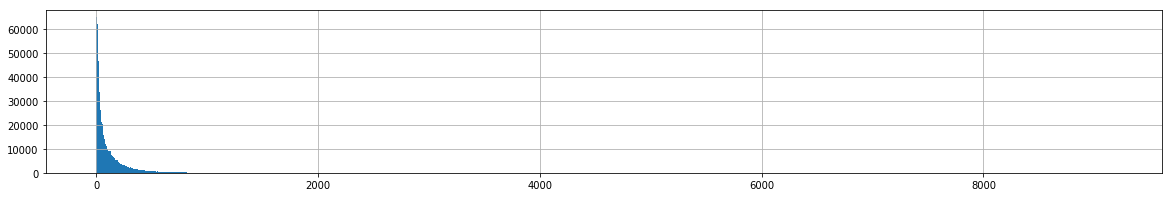

In [530]:
users_to_ratings.hist(bins=1000, figsize=(20, 3))

In [531]:
users_to_ratings.shape, users_to_ratings[users_to_ratings>1000].shape

((478018,), (1374,))

In [532]:
active_users = users_to_ratings[users_to_ratings>1000].index

In [533]:
movies_to_ratings = dataset['MovieID'].value_counts()

In [534]:
movies_to_ratings.shape, movies_to_ratings[movies_to_ratings>15000].shape

((9210,), (805,))

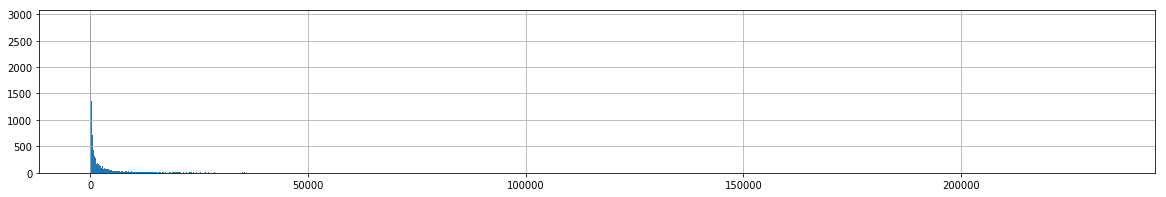

In [536]:
movies_to_ratings.hist(bins=1000, figsize=(20, 3))

In [537]:
popular_movies = movies_to_ratings[movies_to_ratings>15000].index

In [538]:
df = dataset[dataset.MovieID.isin(popular_movies) & dataset.CustomerID.isin(active_users)]

In [539]:
df.shape

(736362, 4)

## Таблица с фичами для фильмов

In [540]:
if txtfile:
    del txtfile
    
with open('Task2/netflix-prize-data/movie_titles.csv', 'r') as f:
    txtfile = f.read()

subs = re.compile(r'\d+,\d+,')
new_lines = []
for i in txtfile.split('\n'):
    sub_part = subs.sub('', i)
    if 'NULL' not in sub_part:
        if ',' not in sub_part:
            new_lines.append(i)
        else:
            left_part = i.replace(sub_part, '')
            right_part = sub_part
            new_lines.append(left_part + '"' + right_part + '"')
        
movie_info = '\n'.join(new_lines)
movie_table = pd.read_csv(StringIO(movie_info), names = ['MovieID', 'Year', 'Name'])

movie_table.MovieID = movie_table.MovieID.astype(int)
movie_table.Year = movie_table.Year.astype(int)

In [541]:
movie_table_filtered = movie_table[movie_table.MovieID.isin(popular_movies.values)]

In [542]:
movie_table_filtered = movie_table_filtered.set_index('MovieID')

In [543]:
features = df.CustomerID.unique().shape[0] + movie_table_filtered.Year.unique().shape[0] + movie_table_filtered.shape[0]

In [544]:
print('Число фичей', features)

Число фичей 2238


In [545]:
k = 3
print('Число параметров в модели', 1 + features + k*features)

Число параметров в модели 8953


### Формируем датасет для обучения

In [546]:
max_movies = popular_movies.shape[0]
max_users = active_users.shape[0]
max_years = movie_table_filtered.Year.unique().shape[0]

In [547]:
#encode year
years_mapping = dict(zip(movie_table_filtered.Year.unique(), range(movie_table_filtered.Year.unique().shape[0])))
users_mapping = dict(zip(active_users, range(active_users.shape[0])))
movies_mapping = dict(zip(popular_movies, range(popular_movies.shape[0])))

In [548]:
X = []
y = []
count = 1
for _, i in df.iterrows():
    if count % 20000 == 0:
        print('%.2f' % (count / df.shape[0]))
        
    id_movie = i['MovieID']
    id_customer = i['CustomerID']
    rating = i['Rating']
    year = movie_table_filtered.loc[id_movie].Year
    row = np.zeros(features)
    
    row[movies_mapping[id_movie]] = 1
    row[max_movies + users_mapping[id_customer]] = 1
    row[max_movies + max_users + years_mapping[year]] = 1
    
    X.append(row)
    y.append(rating)
    count += 1

0.03
0.05
0.08
0.11
0.14
0.16
0.19
0.22
0.24
0.27
0.30
0.33
0.35
0.38
0.41
0.43
0.46
0.49
0.52
0.54
0.57
0.60
0.62
0.65
0.68
0.71
0.73
0.76
0.79
0.81
0.84
0.87
0.90
0.92
0.95
0.98


In [549]:
X = np.array(X)

### сожмем матрицу

In [550]:
X_sparse = csr_matrix(X)

In [551]:
y = np.array(y).reshape(-1, 1)

In [552]:
os.makedirs('./Task2/processed/', exist_ok=True)
joblib.dump(X_sparse, './Task2/processed/X.bin')
joblib.dump(y, './Task2/processed/y.bin')

['./Task2/processed/y.bin']

### попытка обучить модель

In [510]:
y = joblib.load('./Task2/processed/y.bin')
X = joblib.load('./Task2/processed/X.bin')

In [553]:
y = np.array(y).squeeze()

In [512]:
X = np.array(X.todense())

In [554]:
X, y = shuffle(X, y)

In [559]:
rmse_train = []
rmse_test = []
r2_train = []
r2_test = []
r2_adj_train = []
r2_adj_test = []
features = []
features_names = []

kfold = KFold(n_splits=4)

count = 1
for ix_train, ix_test in kfold.split(X):
    print('{}-th fold'.format(count))
    mdl = SGD2WAYFactorizationMachine(epochs=X.shape[0], batch_size=16, k=2, step=.001, step_V=0.00001)
    
    X_train = X[ix_train]
    y_train = y[ix_train]
    
    X_test = X[ix_test]
    y_test = y[ix_test]
    
    mdl.fit(X_train, y_train)
    
    rmse_test.append(RMSE_score(mdl.predict(X_test), y_test))
    r2_test.append(R2_score(mdl.predict(X_test), y_test))
    r2_adj_test.append(R2_adj_score(mdl.predict(X_test), y_test, X.shape[1]))
    
    rmse_train.append(RMSE_score(mdl.predict(X_train), y_train))
    r2_train.append(R2_score(mdl.predict(X_train), y_train))
    r2_adj_train.append(R2_adj_score(mdl.predict(X_train), y_train, X.shape[1]))
    
    count += 1

1-th fold
2-th fold
3-th fold
4-th fold


In [561]:
df = pd.DataFrame(np.vstack([r2_test, r2_train, r2_adj_test, r2_adj_train, rmse_test, rmse_train]), index=[
    'r2_test',
    'r2_train',
    'r2_adj_test',
    'r2_adj_train',
    'rmse_test',
    'rmse_train',
])

df = pd.concat([df, df.mean(axis=1).rename('mean'), df.std(axis=1).rename('std')], axis=1)

df

,0,1,2,3,mean,std
r2_test,0.263924,0.261126,0.261670,0.261086,0.261952,0.001342
r2_train,0.264426,0.266635,0.266667,0.267367,0.266274,0.001277
r2_adj_test,0.254866,0.252033,0.252584,0.251992,0.252869,0.001358
r2_adj_train,0.261433,0.263651,0.263683,0.264386,0.263288,0.001282
rmse_test,0.951213,0.954473,0.951858,0.952045,0.952397,0.001429
rmse_train,0.950771,0.948861,0.949592,0.949201,0.949606,0.000832
